# Problem 4 &mdash; Trends in SFR, Mass, and Metallicity

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import os

import fsps
import emcee
import corner
os.chdir('/Users/iene/modules/BCES')
import bces

## Part (a)

In [172]:
### read in data
os.chdir('/Users/iene/Documents/Classes/ay250_fall2016/pset5/')
data = np.genfromtxt('ps5.txt',usecols = (0,7,8,10,11,12,13,14), dtype=[('Name','S12'),('D','f8'),\
        ('B','f8'),('EBV','f8'),('FUV','f8'),('e_FUV','f8'),('NUV','f8'),('e_NUV','f8')], unpack=True)

In [173]:
### check is there are any missing B mags values
b_mags = data['B']
print(np.where(data['B']==99.99))
### check if there are any missing FUV values
fuv_mags = data['FUV']
print(np.where(data['FUV']==99.99))
### check if there are any missing error FUV values
e_FUV = data['e_FUV']
print(np.where(data['e_FUV']==99.99))

(array([], dtype=int64),)
(array([  0,   9,  12,  17,  48,  51,  53,  57,  62,  86,  90,  94,  97,
        98, 100, 104, 105, 106, 107, 108, 109, 110, 114, 119, 120, 121,
       133, 136, 143, 148, 152, 155, 176, 178, 180, 184, 188, 212, 232,
       241, 253, 264, 266, 267, 270, 319, 333, 340, 341, 342, 345, 355,
       356, 359, 363, 367, 375, 376, 379, 382, 384, 388, 389, 390, 395,
       396, 397, 398, 406, 407, 408, 410, 412, 413, 415, 416, 420, 423,
       424, 430]),)
(array([  0,   9,  12,  17,  48,  51,  53,  57,  62,  70,  80,  86,  90,
        94,  97,  98, 100, 103, 104, 105, 106, 107, 108, 109, 110, 114,
       119, 120, 121, 133, 136, 142, 143, 147, 148, 152, 155, 176, 178,
       180, 184, 188, 212, 231, 232, 239, 241, 253, 264, 266, 267, 270,
       319, 333, 340, 341, 342, 345, 346, 355, 356, 359, 363, 367, 375,
       376, 379, 382, 384, 388, 389, 390, 395, 396, 397, 398, 406, 407,
       408, 410, 412, 413, 415, 416, 420, 423, 424, 430, 437, 444, 446,
       447, 449,

In [174]:
### assign a random error of 0.5 to all the galaxies where we don't have e_FUV, but we do have FUV
e_FUV[np.where((e_FUV==99.99)&(fuv_mags!=99.99))] = 0.5

In [175]:
### only choose good data points
good = np.where(fuv_mags!=99.99)

In [176]:
### generate random gaussian errors of order 0.1 for B-mags
b_err = np.random.normal(loc=0.0, scale=0.1, size=len(good[0]))

Propagating errors resulted in some nice cancellations.

In [177]:
### convert B-band luminosities to mass using the relation derived in Problem 2
app_b_mags = b_mags[good]

### constants
L_sun = 3.846 * 10**33 # erg/s
pc = 3.085677581467192 * 10**18 # cm
m_ab0 = -2.5 * np.log10(3631 * 10**(-23)) # AB magnitude zero point
h = 6.6260755 * 10**(-27) # erg s
c = 2.99792458 * 10**18 # angstrom/s

# area correspoding to d=10pc
A_B = 4 * np.pi * (data['D'][good]*pc*10**6)**2

# flux
f_B = 10**(-0.4*(app_b_mags+m_ab0))

# luminosity 
L_B = A_B * f_B

# log(M_*)
log_masses = 0.072909210643423386*np.log10(L_B) -1.5429471056583883

# errors in log(SFR)
log_masses_err = 0.072909210643423386 * 0.4 * b_err

In [178]:
### compute SFR using the relation derived in Problem 1

### constants
L_sun = 3.846 * 10**33 # erg/s
pc = 3.085677581467192 * 10**18 # cm
m_ab0 = -2.5 * np.log10(3631 * 10**(-23)) # AB magnitude zero point
h = 6.6260755 * 10**(-27) # erg s
c = 2.99792458 * 10**18 # angstrom/s

# get filter
fuv = fsps.get_filter('galex_fuv')

# compute frequency
fuv_freq = c / fuv.lambda_eff

# area correspoding to d=10pc
A = 4 * np.pi * (data['D'][good]*pc*10**6)**2

# flux
f_fuv = 10**(-0.4*(fuv_mags[good]+m_ab0))

# luminosity as needed by Kennicutt eqn 12
L_fuv = fuv_freq * A * f_fuv

# log(SFR)
log_SFR = np.log10(L_fuv) - 43.3426047809

# errors in log(SFR)
log_SFR_err = 0.4 * e_FUV[good]

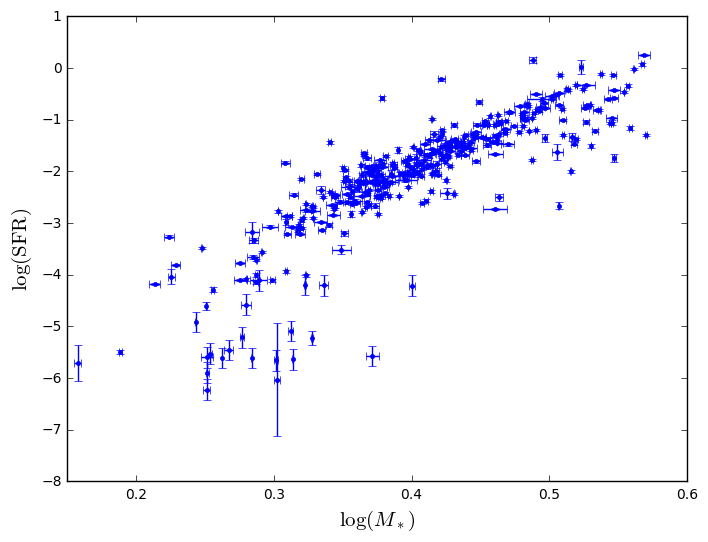

In [179]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(log_masses, log_SFR, xerr = log_mass_err, yerr=log_SFR_err, fmt='.')
plt.ylabel(r'$\log({\rm SFR})$', fontsize=15)
plt.xlabel(r'$\log(M_*)$', fontsize=15)
plt.show()

## Part (b)

Thanks to ''Numerical Recipes'', I found out that in the case of both x and y errors, the log likehood formula is:

\begin{equation}
\log P_i \sim exp \bigg(\frac{y_i-m*x_i-b}{\sigma_{y_i}^2 + b^2 * \sigma_{x_i}^2}\bigg)
\end{equation}.

In [198]:
cov = np.cov(log_mass_err, log_SFR_err)

In [199]:
# linear regression
a,b,aerr,berr,covab=bces.bces(log_masses,log_mass_err,log_SFR,log_SFR_err,cov)

In [200]:
print(a[0], b[0], aerr[0], berr[0])

(12.911975186588773, -7.2564344424922353, 0.55257603247105413, 0.2373972534279099)


In [201]:
### probabilites here
def lnlike(theta, x, y, xerr, yerr):
    m, b = theta[0], theta[1]
    model = m * x + b
    return -0.5*np.sum((y-model)**2/(yerr**2+b**2*xerr**2) + np.log(2*np.pi*(yerr**2+b**2*xerr**2)))

def lnprior(theta):
    m, b = theta[0], theta[1]
    return 0

def lnprob(theta, x, y, xerr, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, xerr, yerr)

In [202]:
### emcee garbage here
ndim, nwalkers = 2, 50
pos = [np.array([12.,-7.])+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(log_masses,log_SFR,log_mass_err,log_SFR_err))
pos1, prob, state = emcee_sampler.run_mcmc(pos, 1000)
emcee_sampler.reset()
emcee_sampler.run_mcmc(pos1, 5000, rstate0=state);

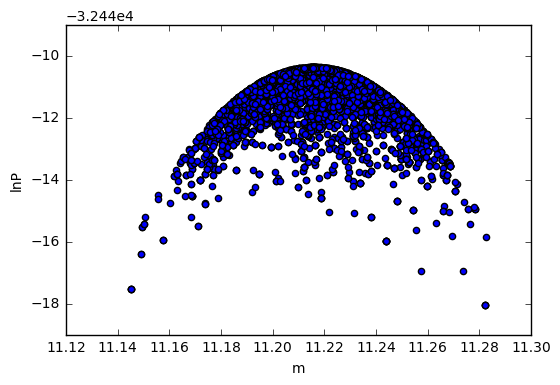

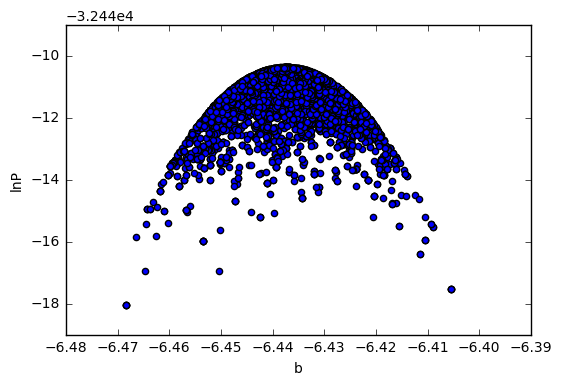

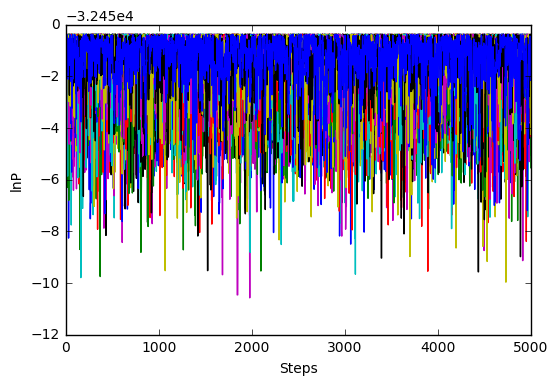

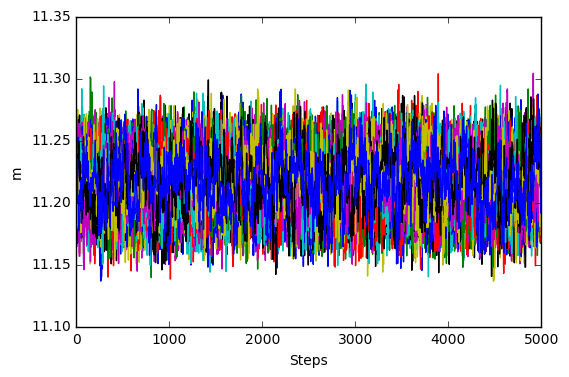

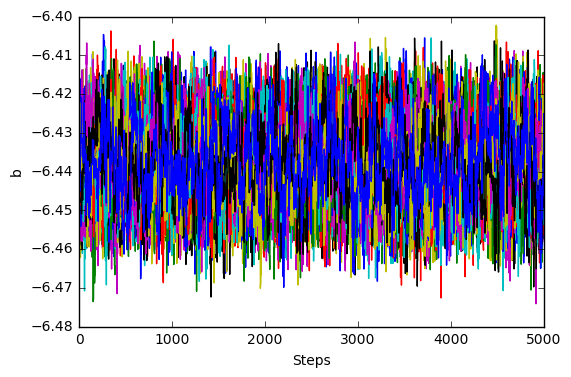

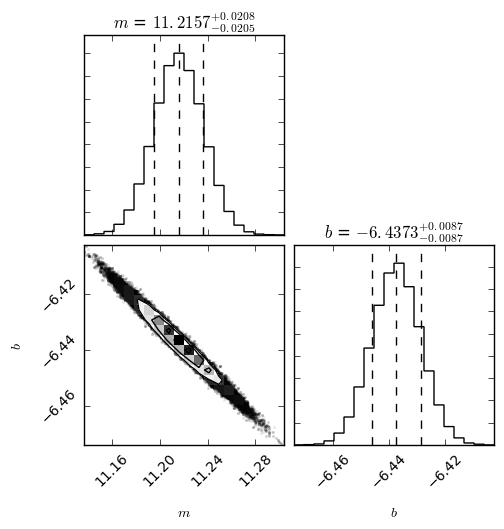

In [203]:
[plt.scatter(emcee_sampler.chain[i,:,0], emcee_sampler.lnprobability[i,:]) for i in range(1)]
plt.xlabel('m')
plt.ylabel('lnP')
plt.show()

[plt.scatter(emcee_sampler.chain[i,:,1], emcee_sampler.lnprobability[i,:]) for i in range(1)]
plt.xlabel('b')
plt.ylabel('lnP')
plt.show()

[plt.plot(emcee_sampler.lnprobability[i,:]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel('lnP')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,0]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel('m')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,1]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel('b')
plt.show()

emcee_samples = emcee_sampler.chain[:,:, :].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["$m$", "$b$"], quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.4f')
plt.show(fig)

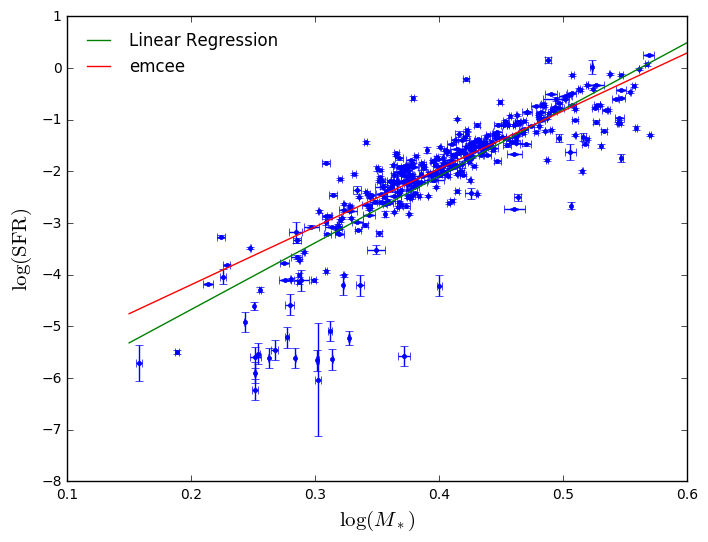

In [204]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(log_masses, log_SFR, xerr = log_mass_err, yerr=log_SFR_err, fmt='.')
plt.ylabel(r'$\log({\rm SFR})$', fontsize=15)
plt.xlabel(r'$\log(M_*)$', fontsize=15)
plt.plot(np.linspace(0.15,0.6,50),a[0]*np.linspace(0.15,0.6,50)+b[0],c='g',label='Linear Regression')
plt.plot(np.linspace(0.15,0.6,50),11.2157*np.linspace(0.15,0.6,50)-6.4373,c='r', label='emcee')
plt.legend(loc=2, frameon=False)
plt.show()

## Part (c)  -- same as in parts (a) and (b), but with metallicity

In [189]:
### compute metallicities using the relationship of Problem 3
abs_b_mags = app_b_mags - 5. * np.log10(data['D'][good] * 10**5)
mets = 6.27 - 0.11 * abs_b_mags
# errors in metallicities
mets_err = -0.11 * b_errors

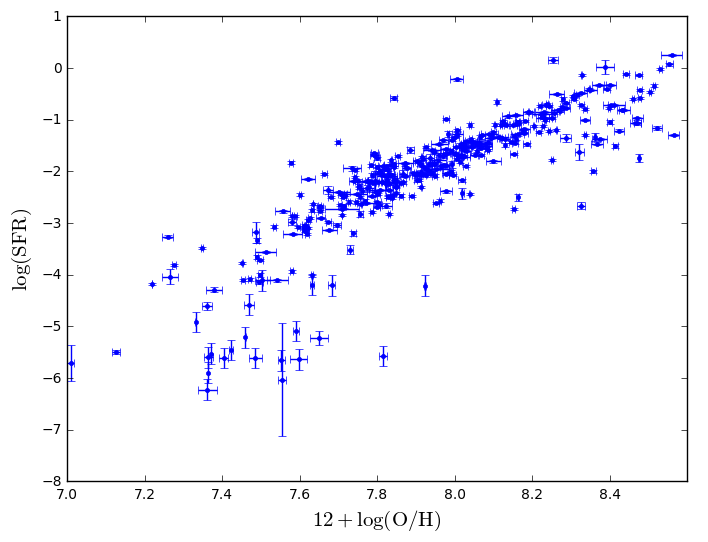

In [190]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(mets, log_SFR, xerr = mets_err, yerr=log_SFR_err, fmt='.')
plt.ylabel(r'$\log({\rm SFR})$', fontsize=15)
plt.xlabel(r'$12 + \log({\rm O/H})$', fontsize=15)
plt.show()

In [191]:
cov = np.cov(mets_err, log_SFR_err)

In [192]:
# linear regression
a,b,aerr,berr,covab=bces.bces(mets,mets_err,log_SFR,log_SFR_err,cov)

In [193]:
print(a[0],b[0],aerr[0],berr[0])

(3.4663200812736443, -29.555954715904136, 0.14634082161180592, 1.1739736131546734)


In [194]:
### probabilites here
def lnlike(theta, x, y, xerr, yerr):
    m, b = theta[0], theta[1]
    model = m * x + b
    return -0.5*np.sum((y-model)**2/(yerr**2+b**2*xerr**2))

def lnprior(theta):
    m, b = theta[0], theta[1]
    return 0

def lnprob(theta, x, y, xerr, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, xerr, yerr)

In [195]:
### emcee garbage here
ndim, nwalkers = 2, 50
pos = [np.array([3.,-29.])+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mets,log_SFR,mets_err,log_SFR_err))
pos1, prob, state = emcee_sampler.run_mcmc(pos, 1000)
emcee_sampler.reset()
emcee_sampler.run_mcmc(pos1, 5000, rstate0=state);

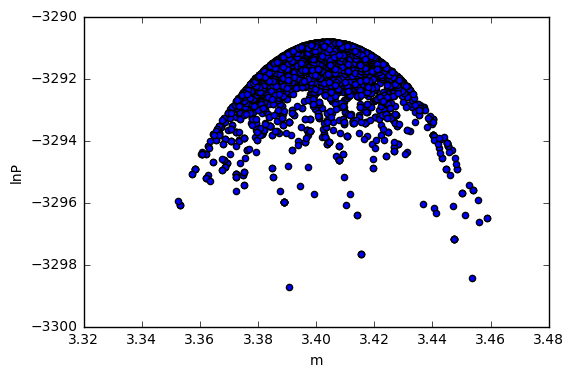

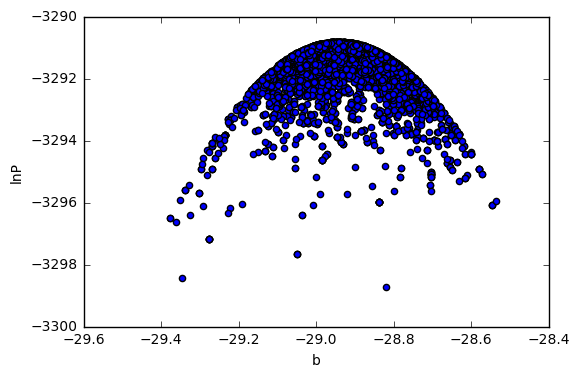

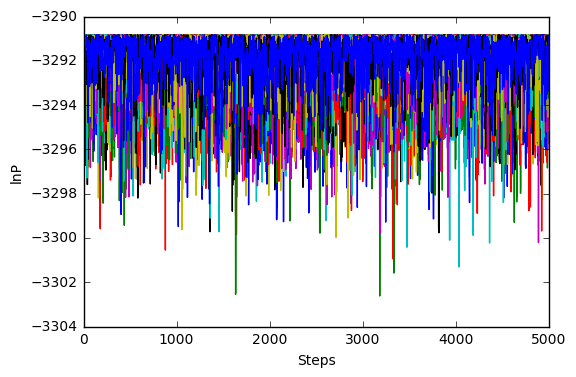

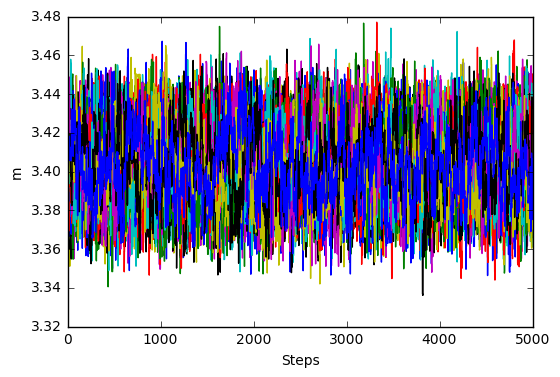

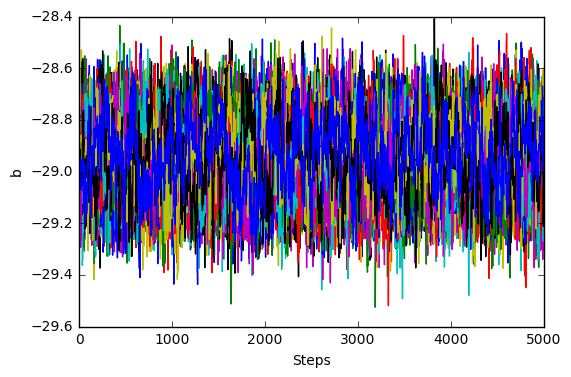

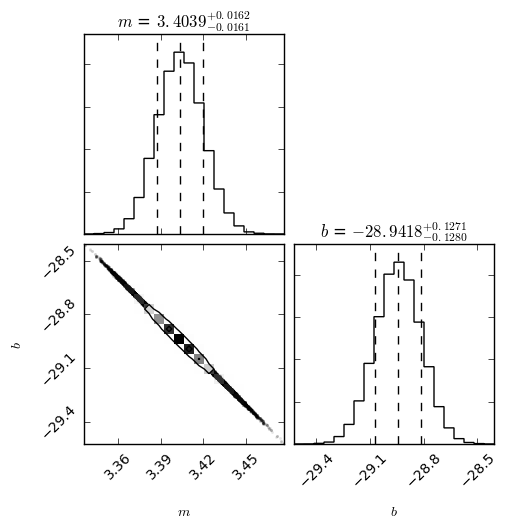

In [196]:
[plt.scatter(emcee_sampler.chain[i,:,0], emcee_sampler.lnprobability[i,:]) for i in range(1)]
plt.xlabel('m')
plt.ylabel('lnP')
plt.show()

[plt.scatter(emcee_sampler.chain[i,:,1], emcee_sampler.lnprobability[i,:]) for i in range(1)]
plt.xlabel('b')
plt.ylabel('lnP')
plt.show()

[plt.plot(emcee_sampler.lnprobability[i,:]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel('lnP')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,0]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel('m')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,1]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel('b')
plt.show()

emcee_samples = emcee_sampler.chain[:,:, :].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["$m$", "$b$"], quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.4f')
plt.show(fig)

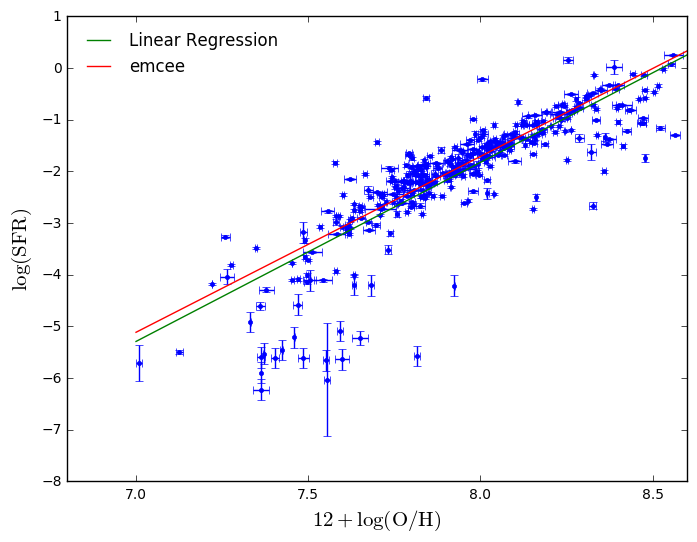

In [197]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(mets, log_SFR, xerr = mets_err, yerr=log_SFR_err, fmt='.')
plt.ylabel(r'$\log({\rm SFR})$', fontsize=15)
plt.xlabel(r'$12 + \log({\rm O/H})$', fontsize=15)
plt.plot(np.linspace(7.,8.6,50),a[0]*np.linspace(7.,8.6,50)+b[0],c='g', label='Linear Regression')
plt.plot(np.linspace(7.,8.6,50),3.4039*np.linspace(7.,8.6,50)-28.9418,c='r', label='emcee')
plt.legend(loc=2, frameon=False)
plt.show()

# Problem 5 &mdash; Caveats

Some caveats of the analysis we have done are the fact that we have assumed a constant star formation history, a Kroupa IMF, a particular stellar template library, and solar metallicity. In order the verify the robustness of the results, we would have to do the same analysis for different version of SFH (for e.g., including starbursts), other types of IMF, using different template libraries and non-solar metallicities. 

Using B-band magnitudes a proxy for stellar mass comes with the already mentioned issues of being sensitive to dust and recent star formation more than redder magnitudes, so it would be helpful to have redder bands and maybe K-band data.


Another aspect to worry about would be dust attenuation and the fact that the dust attenuation law could be different for different galaxies.


Another source of errors could come from the fact that we do not have uncertainties on the distances and the fact that we had to randomly assign errors to some of the FUV measurements.
